     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.9 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=68c78a084ae9a593e8128e469a4f4b7f02582969e253db00c9f3d4eece9ec201
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
Task 1 & 5: Vary Qubits (n=2, 3, 4) and Visualize

--- QFT Circuit for 2 Qubits ---


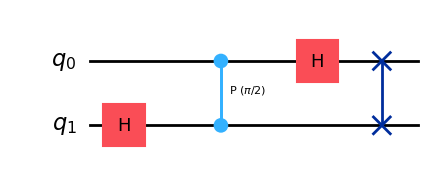

-----------------------------
--- QFT Circuit for 3 Qubits ---


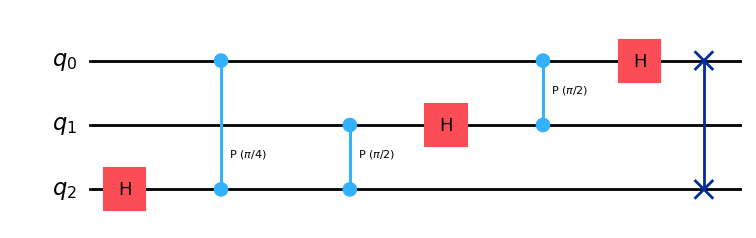

-----------------------------
--- QFT Circuit for 4 Qubits ---


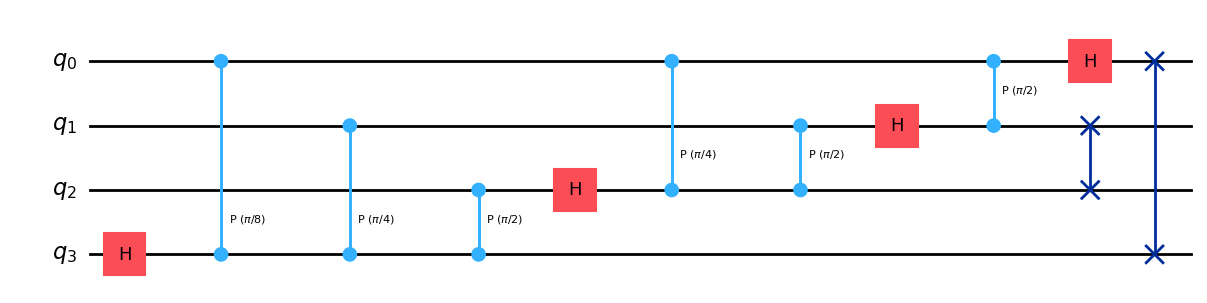

-----------------------------

Task 2, 4, & 5: Implement Inverse QFT and Verify

--- Running and Measuring: QFT-iQFT Test (Input |001>, n=3) ---
Counts: {'001': 2048}


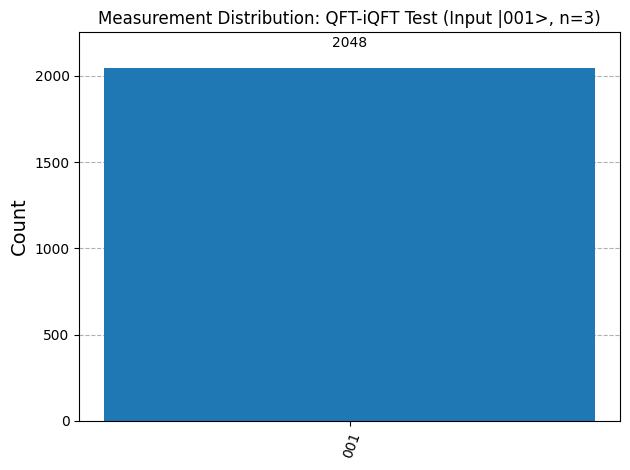

Circuit Diagram (Task 5):


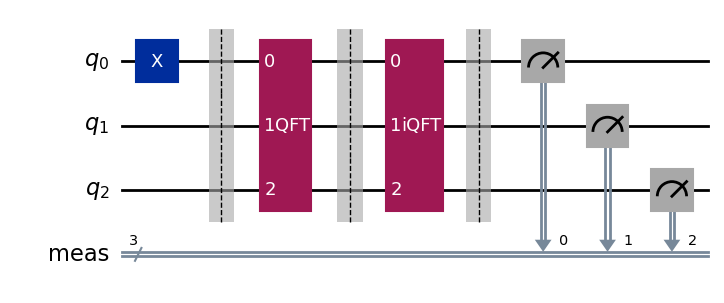

--------------------------------------------------------------

Task 3 & 5: Integration with Phase Estimation

Building Phase Estimation circuit with 3 counting qubits...
Phase Estimation Circuit Diagram (Task 5):


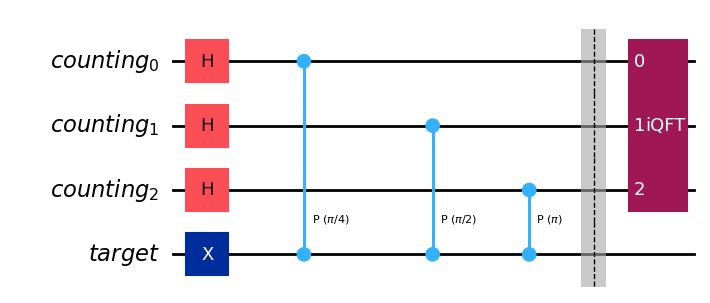


Task 4 & 5: Measure Output States (Phase Estimation)

--- Running and Measuring: Phase Estimation (T-Gate, t=3) ---
Counts: {'001': 2048}


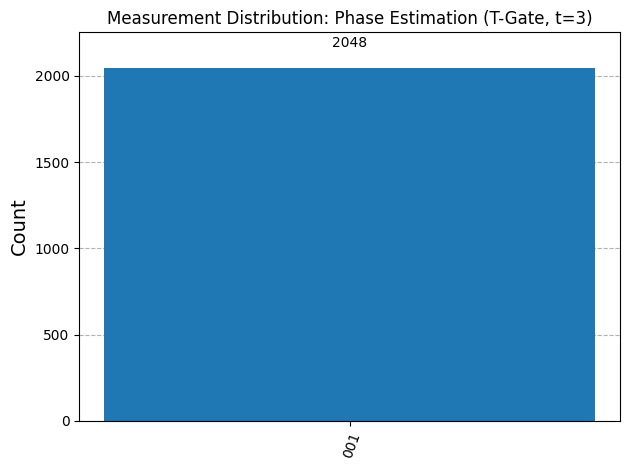

Circuit Diagram (Task 5):


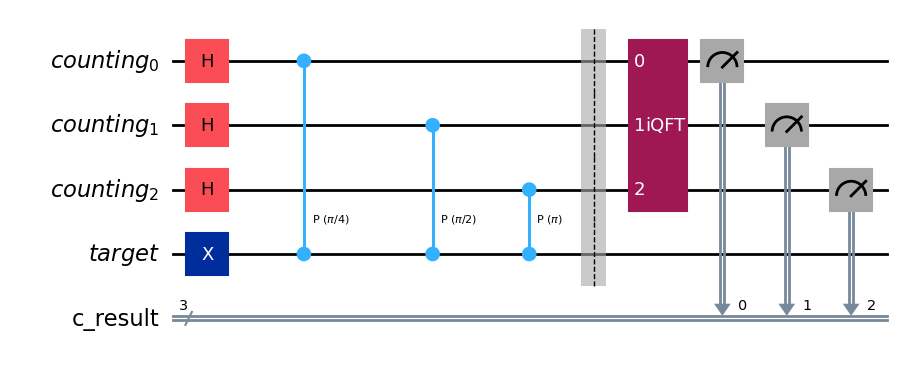

------------------------------------------------------------

Task 5: Circuit Visualization (Summary)

Task 5 (Use qc.draw('mpl')) was performed within each
of the tasks above to display the relevant circuits.

All tasks completed.


In [1]:
# --- PRE-REQUISITE: Install necessary libraries ---
# This step fixes the MissingOptionalLibraryError
!pip install qiskit qiskit_aer pylatexenc

# --- IMPORTS ---
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector

# --- HELPER FUNCTIONS (Original QFT, Inverse QFT, Measurement) ---

# --- QFT Functions ---
def qft_rotations(qc, n):
    """Apply QFT rotations recursively on the first n qubits."""
    if n == 0:
        return qc
    n -= 1
    qc.h(n)
    for qubit in range(n):
        qc.cp(np.pi / 2**(n - qubit), qubit, n)
    qft_rotations(qc, n)
    return qc

def swap_registers(qc, n):
    """Swap qubits to reverse their order."""
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    return qc

def qft_circuit(n):
    """Builds an n-qubit Quantum Fourier Transform circuit."""
    qc = QuantumCircuit(n)
    qft_rotations(qc, n)
    swap_registers(qc, n)
    qc.name = "QFT"
    return qc

# --- Task 2: Inverse QFT Functions ---
def iqft_rotations(qc, n):
    """Apply inverse QFT rotations recursively."""
    if n == 0:
        return qc

    # Recurse first
    iqft_rotations(qc, n - 1)

    # Apply gates for qubit n-1
    n_qubit = n - 1
    for qubit in range(n_qubit):
        qc.cp(-np.pi / 2**(n_qubit - qubit), qubit, n_qubit)
    qc.h(n_qubit)
    return qc

def iqft_circuit(n):
    """Builds an n-qubit Inverse Quantum Fourier Transform circuit."""
    qc = QuantumCircuit(n)

    # 1. Apply swaps (inverse of swaps is swaps)
    swap_registers(qc, n)
    # 2. Apply inverse rotations
    iqft_rotations(qc, n)
    qc.name = "iQFT"
    return qc

# --- Task 3: Phase Estimation Circuit Function ---
def create_phase_estimation_circuit(t_qubits):
    """
    Creates a simple Phase Estimation circuit to find the
    phase of a T-gate (phi = 1/8).

    Args:
        t_qubits (int): The number of counting qubits (precision).
    """
    # t counting qubits + 1 target qubit
    counting_reg = QuantumRegister(t_qubits, name='counting')
    target_reg = QuantumRegister(1, name='target')
    qc = QuantumCircuit(counting_reg, target_reg)

    # 1. Initialize target qubit to |1> (eigenvector of T-gate)
    qc.x(target_reg[0])

    # 2. Apply Hadamard to all counting qubits
    qc.h(counting_reg)

    # 3. Apply controlled-U operations
    for k in range(t_qubits):
        # Apply C-U^(2^k) (U = T gate)
        angle = np.pi / 4 * (2**k)
        qc.cp(angle, counting_reg[k], target_reg[0])

    qc.barrier()

    # 4. Apply Inverse QFT (from Task 2) to counting register
    iqft_gate = iqft_circuit(t_qubits).to_gate()
    qc.append(iqft_gate, counting_reg)

    return qc

# --- Task 4: Measurement Helper Function ---
def run_and_measure(qc, name, simulator):
    """
    Adds measurements, runs simulation, and plots histogram.
    Also performs Task 5 (visualization).
    """
    print(f"--- Running and Measuring: {name} ---")

    # Check if classical bits are needed
    if not qc.cregs:
         qc.measure_all()

    # Transpile and run
    compiled_qc = transpile(qc, simulator)
    result = simulator.run(compiled_qc, shots=2048).result()
    counts = result.get_counts()

    print(f"Counts: {counts}")
    display(plot_histogram(counts, title=f'Measurement Distribution: {name}'))

    # Task 5: Circuit Visualization
    print("Circuit Diagram (Task 5):")
    display(qc.draw('mpl'))
    plt.show()
    print("-" * (len(name) + 30))


# --- MAIN EXECUTION BLOCK (Performing all tasks) ---
if __name__ == "__main__":

    # Create the simulator instance once
    simulator = AerSimulator()

    print("=================================================")
    print("Task 1 & 5: Vary Qubits (n=2, 3, 4) and Visualize")
    print("=================================================\n")
    for n in [2, 3, 4]:
        print(f"--- QFT Circuit for {n} Qubits ---")
        qc_qft = qft_circuit(n)
        # Task 5: Visualize the circuit
        display(qc_qft.draw('mpl'))
        plt.show()
        print("-" * (28 + len(str(n))))

    print("\n=================================================")
    print("Task 2, 4, & 5: Implement Inverse QFT and Verify")
    print("=================================================\n")

    n_iqft = 3
    # We create a test circuit: |001> -> QFT -> iQFT -> Measure
    # We expect to get '001' back with 100% probability
    qc_test = QuantumCircuit(n_iqft)
    qc_test.x(0) # Create state |001>
    qc_test.barrier()

    # Append QFT gate
    qc_test.append(qft_circuit(n_iqft).to_gate(), range(n_iqft))
    qc_test.barrier()

    # Append iQFT gate (Task 2)
    qc_test.append(iqft_circuit(n_iqft).to_gate(), range(n_iqft))

    # Run, Measure (Task 4), and Visualize (Task 5)
    run_and_measure(qc_test, f"QFT-iQFT Test (Input |001>, n={n_iqft})", simulator)

    print("\n=================================================")
    print("Task 3 & 5: Integration with Phase Estimation")
    print("=================================================\n")

    t = 3 # 3 bits of precision (counting qubits)
    print(f"Building Phase Estimation circuit with {t} counting qubits...")
    pe_qc = create_phase_estimation_circuit(t)

    # Task 5: Visualize the PE circuit *before* measurement
    print("Phase Estimation Circuit Diagram (Task 5):")
    display(pe_qc.draw('mpl'))
    plt.show()

    print("\n=================================================")
    print("Task 4 & 5: Measure Output States (Phase Estimation)")
    print("=================================================\n")

    # Now, add measurements to the circuit from Task 3
    pe_creg = ClassicalRegister(t, name='c_result')
    pe_qc.add_register(pe_creg)
    pe_qc.measure(pe_qc.qregs[0], pe_creg) # Measure 'counting' reg

    # We expect phase 1/8 = 0.125.
    # In binary (3 bits): 0.001
    # Qiskit is little-endian, so we expect to measure '001'
    run_and_measure(pe_qc, f"Phase Estimation (T-Gate, t={t})", simulator)

    print("\n=================================================")
    print("Task 5: Circuit Visualization (Summary)")
    print("=================================================\n")
    print("Task 5 (Use qc.draw('mpl')) was performed within each")
    print("of the tasks above to display the relevant circuits.")
    print("\nAll tasks completed.")